<a href="https://colab.research.google.com/github/Abdulhamid97Mousa/Hierarchical_Diagnosis_BearingFaults_B_CNN/blob/main/Hierarchical_Diagnosis_BearingFaults_B_CNN_TF_KERAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#B-CNN Model For Bearing faults Classification

# 1. Introduction
Rolling bearings have been used extensively in rotating machinery such as pumps, turbines, gearboxes, compressors, engines, etc. Rolling bearings are prone to malfunction due to the complexity of rotating equipment and the nature of the operating environment. Lau and Ngan reported that bearing faults account for 40%–50% of all motor failures [1]. Such failure may lead to safety threats, economic losses, and system breakdowns. Therefore, automatic and accurate fault diagnosis for rolling bearings is of great importance to maintain safe and stable operation of mechanical equipment.

Over the past four decades, many fault diagnosis methods have been investigated by researchers and engineers, and these methods have exhibited satisfactory performances in fault detection, fault isolation, and fault identification tasks. Generally, fault diagnosis methods can be categorized into model-based, signal-based, and intelligence-based methods [2], [3]. Model-based methods emulate the industrial process or practical systems from physical principles or systems identification techniques. The algorithms compare the actual measurements obtained from the system with outputs generated by the mathematical model of the system [4]. However, a priori information of the system is a prerequisite when model-based methods are employed, which affects model accuracy. Unlike model-based methods using explicit mathematical formulas, signal-based approaches extract features from measured signals using time-domain [5], [6], frequency-domain [7], [8] or time–frequency-domain [9], [10], [11] approaches. Reference [2] discusses these three signal-based approaches and their wide application ranges. Nevertheless, these methods rely heavily on pattern analysis and prior knowledge of the monitoring system. In practice, this knowledge is largely influenced by human factors and may even be unavailable when the system is nonlinear or working conditions are highly complex [3].

In recent years, machine learning (ML)-based intelligent diagnosis techniques have gained increasing attention and have been applied extensively to rolling bearing diagnosis, such as artificial neural networks [12], principal component analysis [13], and support vector machine (SVM) [14]. ML accommodates large volumes of data to resolve specific trends and patterns that would not be apparent to humans. However, some deficiencies still exist in traditional ML models. For example, it is difficult to extract deep features from raw data, and when working with high-dimensional data, these issues are further complicated by the dimensionality. To address the above drawbacks and enhance the model’s learning ability, a deep learning (DL) technique, as a branch of ML, can be employed. As proposed by Hinton et al. in 2006 [15], DL effectively assembles multiple layers of data processing units to form a deep architecture to extract hidden features of high-dimensional data. Some DL methods, such as the deep belief network (DBN) [16], auto-encoding network [17], [18], [19], recurrent neural network [20], [21], and generative adversarial network (GAN) [22], [23] have achieved great success in the field of fault intelligent diagnosis. Yan et al. [16] presented a multiscale cascading deep belief network (MCDBN) to acquire broader feature representation. Zhang et al. [18] proposed a new ensemble deep contractive auto-encoder to effectively handle the data collected under noisy environments. Wu et al. [20] designed a batch-normalized long-short term memory model to generate auxiliary samples, which can solve the problem of insufficient labeled data. To balance the dataset, Zhou et al. [22] applied a GAN technique to generate discriminant fault samples with a scheme of global optimization.

In particular, convolutional neural networks (CNNs), as one of the representative DL algorithms, have attracted widespread attention since AlexNet [24]. CNN has the characteristics of local perception and parameter sharing, and has demonstrated superior performance in computer vision and fault diagnosis. Janssens et al. [25] utilized CNN for the first time to diagnose bearing faults of rotating machinery and obtained satisfactory results. Since their pioneering work, many methods have been proposed for applying CNN for bearing fault diagnosis [26], [27], [28], [29], [30], [31]. Wang et al. [26] constructed CNN-based hidden Markov models to classify multi-faults in mechanical systems. To address the variation in operating conditions, Hu et al. [27] introduced a tensor-aligned invariant subspace learning and two-dimensional CNN for cross-domain intelligent bearing fault diagnosis. Wen et al. [29] developed a new transfer CNN, ResNet-50, with a depth of 51 convolutional layers that achieves high accuracy by incorporating transfer learning techniques. The success of DL models is attributed to the consistency of the training and test datasets. In practice, the collected data may be affected by environmental noise and variable working conditions. Therefore, it is necessary to develop a method that can mine features of the data, despite noise interference. Furthermore, to enhance the adaptability of the method, a model trained in one working condition should perform well in other working conditions.

To address the above problems, we propose a hierarchical branch CNN (HB-CNN) model for bearing fault diagnosis. First, the hierarchical structure of the bearing fault is established, which includes three levels of classified labels corresponding to fault detection, fault isolation, and fault identification. Then, a one-dimensional (1-D) CNN is constructed as a basic building block by stacking small convolutional kernels. Finally, the hierarchical structure is combined with the natural stratification of the network, and the HB-CNN is formulated by incorporating the branch structure into the 1-D CNN. The proposed model directly takes 1-D raw data as the input and predicts the hierarchical structure of bearing faults through multiple output layers. When the bearing vibration signals are fed into the HB-CNN model, predictions of bearing state, fault location, and fault size are output simultaneously. To demonstrate the superiority of the HB-CNN, we compared the performance of our HB-CNN scheme with several salient DL models with datasets obtained from Case Western Reserve University (CWRU, Cleveland, OH, USA) [32] and Paderborn University Bearing Data Center (Paderborn, Germany) [33]. The comparison results demonstrated that the proposed model successfully achieves hierarchical diagnosis of bearing faults and exhibits superior robustness even with noise interference and under variable working conditions.

The rest of this paper is organized as follows. Section 2 introduces fundamental theories related to CNNs and hierarchical structures. Section 3 presents the proposed HB-CNN method. In Section 4, the experimental results are analyzed and discussed. Finally, conclusions are drawn in Section 5.

## 1.1 CWRU BEARING DATASET
This notebook shows the study of the [CWRU Bearing Dataset](https://csegroups.case.edu/bearingdatacenter/home), which contains data of normal and fault bearings. Artificial defects of different diameters (0.007 ~ 0.028 Inches) are manufactured at different locations of the bearings: inner raceway(IR), outer raceway(OR) and ball(B) defects. 

Vibration data was recorded for motor loads of 0 to 3 hp (motor speed of 1797 to 1720 RPM) using accelerometers at the drive end (DE) and fan end (FE) and the data is stored as Matlab files. The sampling rate is 12 kHz and each Matlab file contains between ~120k to ~240k sample points. For more information please refer to the [website](https://csegroups.case.edu/bearingdatacenter/home).

This study focuses on the classification of the drive end bearing defects using only the signal data at **DE**. It is a **multiclass classification** problem. The input is the vibration signal data at DE and the output is the type of defects:

*  Normal (N)
*  Fault at Ball (B)
*  Fault at Inner Raceway (IR)
*  Fault at Outer Raceway (OR) 


In [1]:
import errno, os
import requests
import scipy.io as sio
import numpy as np

from os import listdir
from os.path import isfile, join
from zipfile import ZipFile 
from sklearn.model_selection import train_test_split

# Pytorch
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from torch.nn.modules.loss import CrossEntropyLoss

# Others
from IPython.core.debugger import set_trace
from pathlib import Path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.2 Download the dataset - CWRU

The dataset is downloaded from the [Github](https://github.com/Abdulhamid97Mousa/CWRU-dataset-1) repository.                                            
`I Here by admit that i haven't put the files in the correct order by myself, but instead taken the dataset already built structure from this person:` [Contact-Card](https://github.com/s-whynot).
  
The dataset has several matlab files where the name is just a number (such as "118.mat"). It has information such as
1. **State** -
     - `N` for *normal* state, not damaged
     - `B` for *ball* damage
     - `IR` for *inner raceway* damage
     - `OR` for *outer raceway* damage
2. **Fault Diameter** -
    - `007` for 0.007 inch damage
    - `014` for 0.014 inch damage 
    - `021` for 0.021 inch damage
    - `028` for 0.028 inch damage  
    the unit 'mils' is 1/1000th of an inch
3. **Position of the sensor** 
    - *3*, *6*, *12* for *outer raceway* faults located at 3 o’clock, at 6 o’clock and at 12 o’clock respectively of the load zone
4. **Load** can be:
    - *0*, *1*, *2*, *3* for different motor load conditions in Horsepower (HP)

In [3]:
print(os.getcwd())
filename = os.path.join(os.getcwd(), 'repo.zip')
print(filename)

/content
/content/repo.zip


In [4]:
filename = os.path.join(os.getcwd(), 'repo.zip')
url = 'https://github.com/Abdulhamid97Mousa/CWRU-dataset-1/archive/refs/heads/main.zip'

r = requests.get(url)
print(filename)
with open(filename, 'wb') as f:
    f.write(r.content) 

file_name = "/content/repo.zip"
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Finished Extracting!') 

/content/repo.zip
Extracting all the files now...
Finished Extracting!


# 1.3 Edit the downloaded data

Using the data collected at the *Drive End*, which is labeled as the code `DE`, this function picks up the time signal from a file. For the given code, a regex is made on the dictionary keys, looking for the the code and ignoring the rest of the suffix. 

The function also converts the unit to SI.

In [5]:
def acceleration_time_signal(dict_1, code):
    """
    load the time series in the file and convert units in SI
    file= 'filename' from the ./dataset/ folder
    code= ' DE' or 'FE', other code will give error
    """
    import re
    try:
        for key in dict_1:
            # print(key)
            if re.findall(rf"({code})", key):
                dict_code = key
        #inches to meter
        unit_conv = 0.0254
        x = dict_1[dict_code] * unit_conv
        return x
    except:
        print('File does not exist or code wrong. Code must be either "DE or "FE" ')

- 3 different functions are necessary to process the files and the data
- All subfolders scanned recursively with the function `fast_scandir` 

In [6]:
def Read_MAT_files_from_folders(file_path, files_list, code):
  G_data = []
  for i in range(len(files_list)):
    data = sio.loadmat(os.path.join(file_path, files_list[i]))
    sig = acceleration_time_signal(data, code)
    # print('what is signal type and sig len and signal shape', type(sig), len(sig), sig.shape)
    G_data.append(sig)
  
  G_data = np.vstack(G_data).flatten()
  # print("what is G_data", G_data)
  return G_data 

def Percent_data_split(array_1, array_2, percent_1 = 10, index_1 = False):
  if index_1 == False:
    #splitting FE data by percent 
    len_n = array_1.shape[0]
    percent_true = percent_1/100
    x = int(percent_true*len_n) #% split
    data_percent, data_rest = np.split(array_1, [x])
  else:
    #splitting array_1 data by percent of array_2 data
    len_n = array_2.shape[0]
    percent_true = percent_1/100
    x = int(percent_true*len_n) #% split
    data_percent, data_rest = np.split(array_1, [x])

  return data_percent, data_rest

def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    
    return subfolders 

### 1.4 Normal Acceleration data 
CWRU DE 

In [7]:
#12k Normal Signal for DE
file_path_1 = '/content/CWRU-dataset-1-main/Normal'
onlyfiles_1 = [f for f in listdir(file_path_1) if isfile(join(file_path_1, f))]

print(onlyfiles_1)
print(type(onlyfiles_1))
print(len(onlyfiles_1))

G_data_N_DE = Read_MAT_files_from_folders(file_path_1, onlyfiles_1, "DE")
display(G_data_N_DE.shape)
print(type(G_data_N_DE))

['97_Normal_0.mat', '100_Normal_3.mat', '99_Normal_2.mat', '98_Normal_1.mat']
<class 'list'>
4


(1698547,)

<class 'numpy.ndarray'>


### 3.2 Faulty bearing data at DE: 12000 Hz DE  
`12k is the sampling rate fs` 
1. B, 
2. IR, 
3. OR

In [8]:
#12k DE data load
file_path_2 = '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data'
subfolder_path = fast_scandir(file_path_2)
print(subfolder_path)

G_data_OR_007_DE = []
G_data_OR_021_DE = []

for i in range(3, len(subfolder_path), 1):
  dir_1 = subfolder_path[i]
  # print(subfolder_path[i])
  #B
  if 'B/' in dir_1:
    onlyfiles_2_1 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]

    if '007' in dir_1:
    #007
      G_data_B_007_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
    elif '014' in dir_1:
    #014
      G_data_B_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
    elif '021' in dir_1:
    #021
      G_data_B_021_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
    else:
    #028
      G_data_B_028_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
  #B
  #IR
  elif 'IR/' in dir_1:
    onlyfiles_2_2 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]

    if '007' in dir_1:
    #007
      G_data_IR_007_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    elif '014' in dir_1:
    #014
      G_data_IR_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    elif '021' in dir_1:
    #021
      G_data_IR_021_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    else:
    #028
      G_data_IR_028_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
  #IR
  #OR
  elif 'OR/' in dir_1:
    onlyfiles_2_3 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]
    if '007' in dir_1:
      #007
      for i in range(len(onlyfiles_2_3)):
        data_OR_007 = sio.loadmat(os.path.join(dir_1, onlyfiles_2_3[i]))
        or_sig_007 = acceleration_time_signal(data_OR_007, code='DE')
        G_data_OR_007_DE.append(or_sig_007)
    elif '014' in dir_1:
      #014
      G_data_OR_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_3, "DE")
    else:
      #021
      for i in range(len(onlyfiles_2_3)):
        data_OR_021 = sio.loadmat(os.path.join(dir_1, onlyfiles_2_3[i]))
        or_sig_021 = acceleration_time_signal(data_OR_021, code='DE')
        G_data_OR_021_DE.append(or_sig_021)
  #OR 
print("G_data_B_007_DE", G_data_B_007_DE.shape)
print("G_data_B_014_DE", G_data_B_014_DE.shape)
print("G_data_B_021_DE", G_data_B_021_DE.shape)
print("G_data_B_028_DE", G_data_B_028_DE.shape)
G_data_B_DE = np.concatenate((G_data_B_007_DE, G_data_B_014_DE, G_data_B_021_DE), axis=0).flatten()
print("G_data_B_DE", G_data_B_DE.shape)
print("G_data_B_DE type", type(G_data_B_DE))

print("G_data_IR_007_DE", G_data_IR_007_DE.shape)
print("G_data_IR_014_DE", G_data_IR_014_DE.shape)
print("G_data_IR_021_DE", G_data_IR_021_DE.shape)
print("G_data_IR_028_DE", G_data_IR_028_DE.shape)
G_data_IR_DE = np.concatenate((G_data_IR_007_DE, G_data_IR_014_DE, G_data_IR_021_DE), axis=0).flatten()
print("G_data_IR_DE", G_data_IR_DE.shape)

G_data_OR_007_DE = np.vstack(G_data_OR_007_DE).flatten()
print("G_data_OR_007_DE", G_data_OR_007_DE.shape)
G_data_OR_014_DE = np.vstack(G_data_OR_014_DE).flatten()
print("G_data_OR_014_DE", np.shape(G_data_OR_014_DE))
G_data_OR_021_DE = np.vstack(G_data_OR_021_DE).flatten()
print("G_data_OR_021_DE", G_data_OR_021_DE.shape)
G_data_OR_DE = np.concatenate((G_data_OR_007_DE, G_data_OR_014_DE, G_data_OR_021_DE), axis=0).flatten()
print("G_data_OR_DE", np.shape(G_data_OR_DE))      

['/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/OR', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/IR', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/B', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/OR/021', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/OR/007', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/OR/014', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@3', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@6', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@12', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@3', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@6', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@12', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/IR/021', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Faul

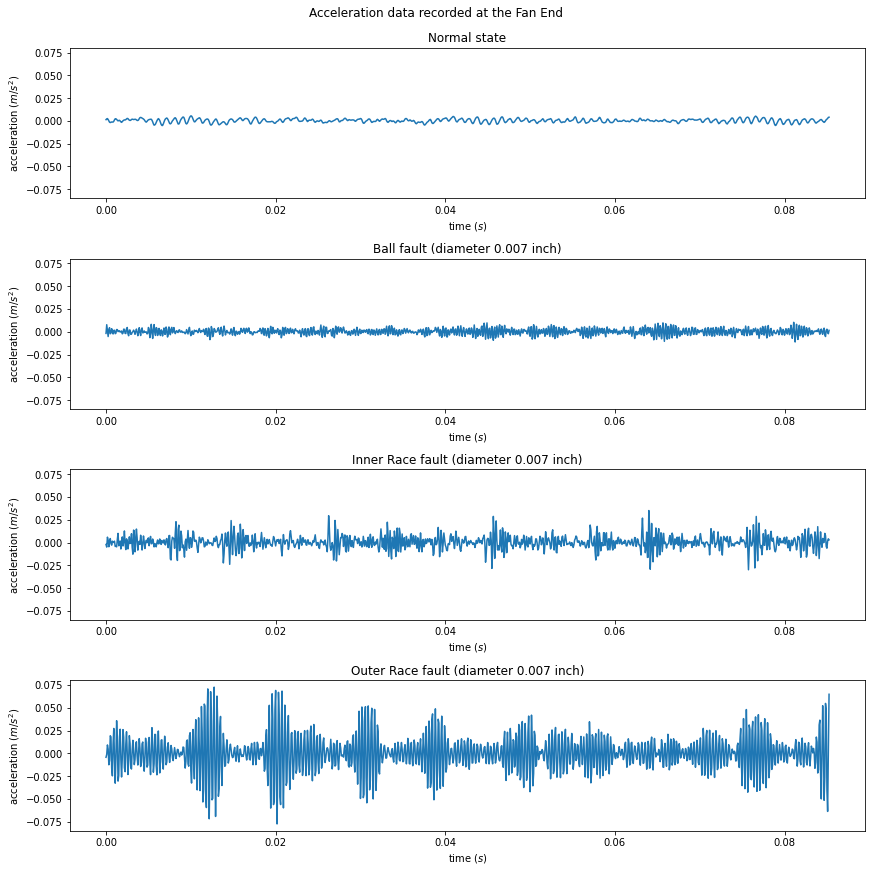

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

range_of_samples = np.arange(0,1024)
fs = 12000

# plotting
fig, axs = plt.subplots(4, 1, sharey=True, figsize=(12, 12), constrained_layout=True)
fig.suptitle('Acceleration data recorded at the Fan End')

axs[0].plot(range_of_samples/fs, G_data_N_DE[range_of_samples])
axs[0].set_title('Normal state')

axs[1].plot(range_of_samples/fs, G_data_B_007_DE[range_of_samples])
axs[1].set_title('Ball fault (diameter 0.007 inch)')

axs[2].plot(range_of_samples/fs, G_data_IR_007_DE[range_of_samples])
axs[2].set_title('Inner Race fault (diameter 0.007 inch)')

axs[3].plot(range_of_samples/fs, G_data_OR_007_DE[range_of_samples])
axs[3].set_title('Outer Race fault (diameter 0.007 inch)')

for ax in axs.flat:
    ax.set(xlabel='time $(s)$', ylabel='acceleration $(m/s^2)$')

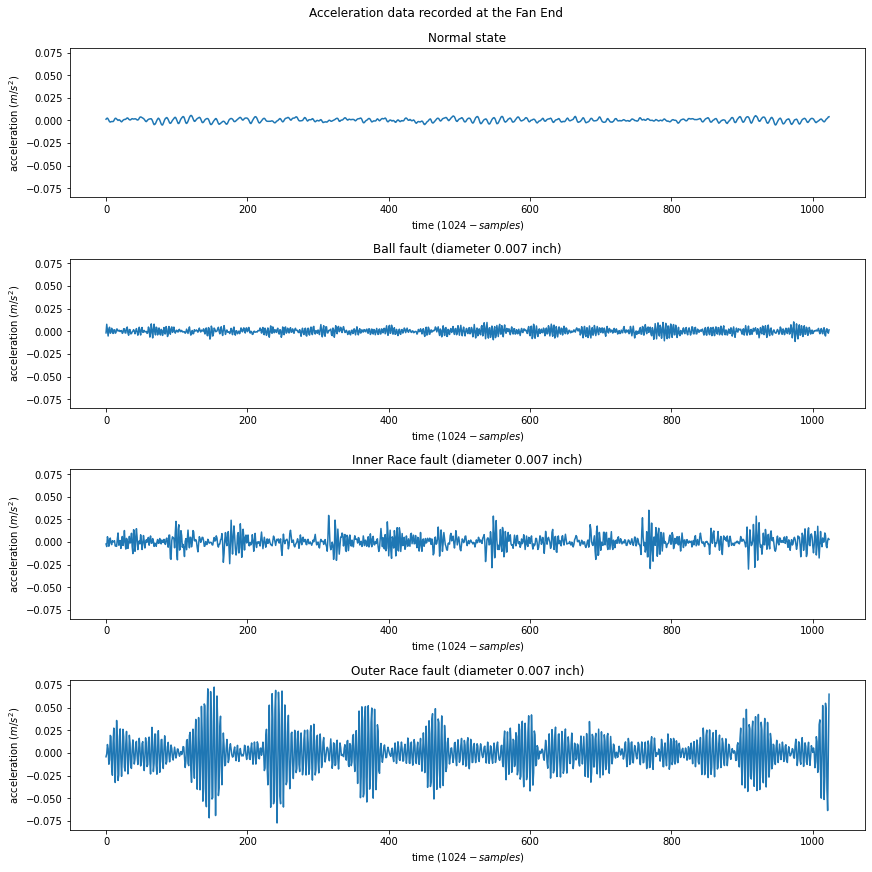

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

range_of_samples = np.arange(0,1024)
fs = 12000

# plotting
fig, axs = plt.subplots(4, 1, sharey=True, figsize=(12, 12), constrained_layout=True)
fig.suptitle('Acceleration data recorded at the Fan End')

axs[0].plot(G_data_N_DE[range_of_samples])
axs[0].set_title('Normal state')

axs[1].plot(G_data_B_007_DE[range_of_samples])
axs[1].set_title('Ball fault (diameter 0.007 inch)')

axs[2].plot(G_data_IR_007_DE[range_of_samples])
axs[2].set_title('Inner Race fault (diameter 0.007 inch)')

axs[3].plot(G_data_OR_007_DE[range_of_samples])
axs[3].set_title('Outer Race fault (diameter 0.007 inch)')

for ax in axs.flat:
    ax.set(xlabel='time $(1024-samples)$', ylabel='acceleration $(m/s^2)$')

## 4. Architecture of the CNN
As the picture in our blogpost shows , we can distinguish 3 main conceptual phases.

1. Data chunking
2. Data labeling `give the data a label 0,1,2 and 3`
2. Data shuffling
3. Convolutional Neural Network

### 4.1. Data chunking
We'll divide the signal in chunks of size `chunk_size`, and take a subset `number_of_chunks` from all the available for training and testing the CNN. A chunk is simply a sequential subset of the time series data with a fixed length - the `chunk_size`. Every chunk is distinct - there are no overlapping samples in different chunks. This method is said tumbling time windowing, for more info you can see this [blog post](https://blog.codecentric.de/en/2018/10/window-functions-in-stream-analytics/). Each time series is an array, and they have slight difference in length. This means that if we fix a chunk size to divide the file, we need a function to split the data exaclty in `number_of_chunks` of `chunk_size` and get rid of the remaining part. We can write a function for that, `split_exact`, which takes the array to be splitted, the number of chunks and the array axis to be splitted.

In [11]:
import math

In [12]:
def split_exact(x, n_chunks=1, axis=1):
    # print("x, n_chunks", np.array(x).shape, n_chunks)
    # L = Length of x
    l = np.shape(x)[axis]
    # print("length of x: ", l)

    # x_split = x
    x_split = x
    if l > n_chunks > 1:
        n = n_chunks
        # print("number of chunks is :", n)
        if axis == 0:
            # x_split returns list of ndarrays A list of sub-arrays

            x_split = np.split(x[:-(l % n)], n, axis=axis)
            # print('np.array l shape: ', l)
            # print('np.array n shape: ', n)
            # print("x[:-(l / n)]", len(x[:-(l % (n + 1))]))
            # print("number of sub arrays: ", np.array(x_split).shape)
        elif axis == 1:
            x_split = np.split(x[:, :-(l // n)], n,  axis=axis)
    return x_split

Some operations were performed on the data. 

For the CWRU Data only - ignoring the 0.028 inch fault diameter from `IR` and `B`, only considering the rest:

* the **normal** data labelled as `N` - Baseline

* the **inner raceway** data labelled as `IR`
      1.for 0.007 inch fault diameter
      2.for 0.014 inch fault diameter
      3.for 0.021 inch fault diameter
* the **ball** data labelled as `B`
      1.for 0.007 inch fault diameter
      2.for 0.014 inch fault diameter
      3.for 0.021 inch fault diameter
* the **outer raceway** data labelled as `OR`
      1.for 0.007 inch fault diameter
      2.for 0.014 inch fault diameter
      3.for 0.021 inch fault diameter

For every load, the data is joined from `0...3` HP load, normalizing it with respect to the *standard deviation*. This is because the load is not considered in *Classification*. 

Several functions needed, such as; `load_raw_matlab_data` which returns several multidimensional arrays for `N`, `IR`, `B` and `OR` data with dimension of the maximum `number_of_chunks` obtainable from the data, by `chunk_size`. 

In [59]:
def split_array_into_chunks(array, size):
    length_of_array = len(array)
    print("length of array given: ", length_of_array)
    num_chunks = length_of_array // size
    print("num_chunks: ",num_chunks)
    last = num_chunks * size
    X_new = array[:last]
    # print(X_new.shape)
    X_chunk = np.array_split(X_new, num_chunks)

    X_chunk = np.array(X_chunk)
    
    print("Output shape: ", np.array(X_chunk).shape)

    return X_chunk

Initializing the data using the latter function.

### 4.1.1 Source Domain data chunk



### 3.1.1. Hierarchical structure of bearing fault data
In an actual production process, bearing faults are mainly divided into two diagnosis requirements: simple diagnosis and accurate diagnosis. The simple diagnosis is to identify the bearing state and determine whether there is fault in the bearing. For precise diagnosis, it is necessary to further analyze the location and severity of the bearing fault in detail.

Based on the actual diagnosis requirements, bearing faults are divided into three levels in this study: fault detection, fault isolation, and fault identification. Taking the CWRU dataset as an example, the hierarchical structure construct is shown in Fig. 3. We use “level” to represent different layers in the hierarchical structure and “layer” to represent layers in the neural network. By dividing data categories hierarchically, errors can be limited to a subcategory. For example, the model may not be able to distinguish whether the fault diameter on the outer race is 0.007 or 0.014, but it can distinguish that the fault is located on the outer race as opposed to the inner race.

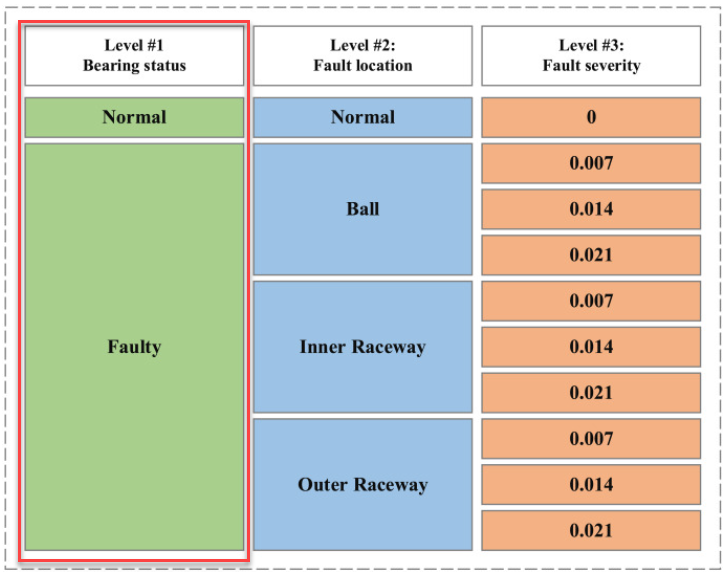

In [60]:
size = 1024
#-DE data
Normal_Bearing_status = split_array_into_chunks(G_data_N_DE, size)
print("Normal_Bearing_status", np.shape(Normal_Bearing_status))

Faulty = np.concatenate((G_data_B_007_DE, G_data_B_014_DE, G_data_B_021_DE,
                                  G_data_IR_007_DE, G_data_IR_014_DE, G_data_IR_021_DE, 
                                  G_data_OR_007_DE, G_data_OR_014_DE, G_data_OR_021_DE), axis=0).flatten()
                                  
print("---------------")
Faulty_Bearing_status = split_array_into_chunks(Faulty, size)

print("Faulty_Bearing_status", np.shape(Faulty_Bearing_status))
print("---------------")
 

length of array given:  1698547
num_chunks:  1658
Output shape:  (1658, 1024)
Normal_Bearing_status (1658, 1024)
---------------
length of array given:  6344600
num_chunks:  6195
Output shape:  (6195, 1024)
Faulty_Bearing_status (6195, 1024)
---------------


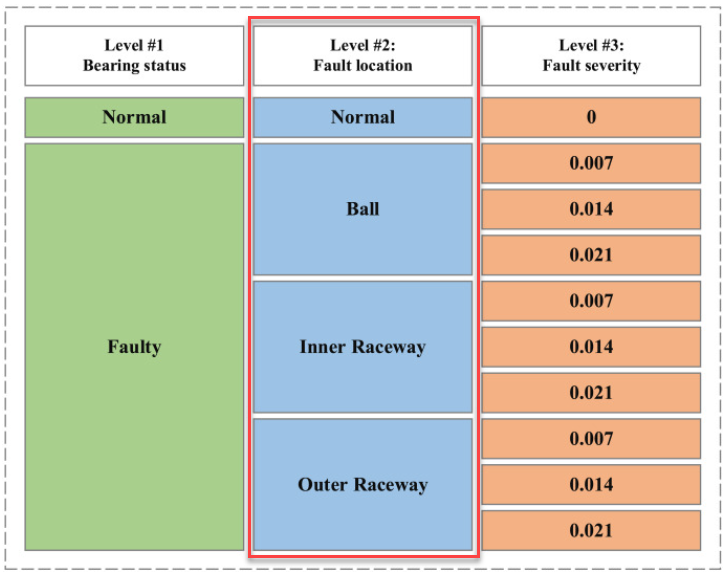

In [61]:
#DE data
Normal_fault_location = split_array_into_chunks(G_data_N_DE, size)

print("Normal_fault_location", np.shape(Normal_fault_location))

print("---------------")
ball_fault_location = split_array_into_chunks(G_data_B_DE, size)
print("ball_fault_location", np.shape(ball_fault_location))
print("---------------")
ir_fault_location = split_array_into_chunks(G_data_IR_DE, size)
print("ir_fault_location", np.shape(ir_fault_location))
print("---------------")
or_fault_location = split_array_into_chunks(G_data_OR_DE, size)
print("or_fault_location", np.shape(or_fault_location)) 

length of array given:  1698547
num_chunks:  1658
Output shape:  (1658, 1024)
Normal_fault_location (1658, 1024)
---------------
length of array given:  1463166
num_chunks:  1428
Output shape:  (1428, 1024)
ball_fault_location (1428, 1024)
---------------
length of array given:  1463077
num_chunks:  1428
Output shape:  (1428, 1024)
ir_fault_location (1428, 1024)
---------------
length of array given:  3418357
num_chunks:  3338
Output shape:  (3338, 1024)
or_fault_location (3338, 1024)


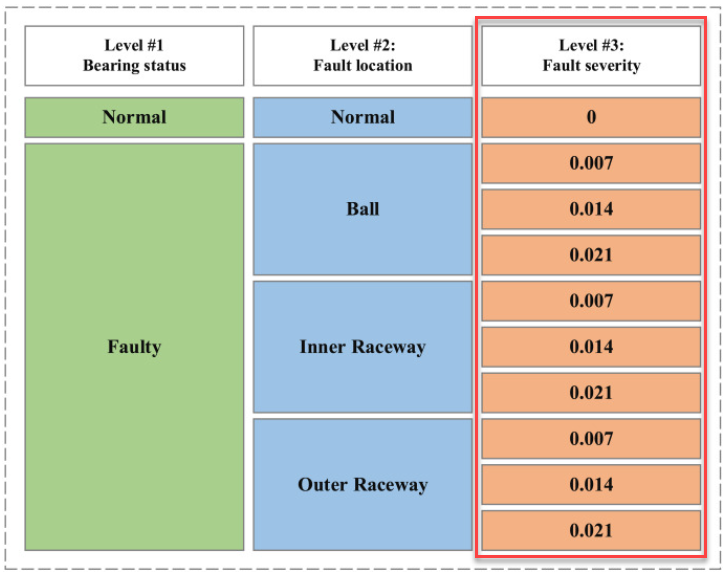

In [63]:

#DE data
Normal_fault_severity = split_array_into_chunks(G_data_N_DE, size)
print("Normal_fault_severity", np.shape(Normal_fault_severity))
# type normal_data_chunk_DE <class 'list'>
print("---------------")
ball_fault_diameter_007 = split_array_into_chunks(G_data_B_007_DE, size)
print("ball_fault_diameter_007", np.shape(ball_fault_diameter_007))

ball_fault_diameter_014 = split_array_into_chunks(G_data_B_014_DE, size)
print("ball_fault_diameter_014", np.shape(ball_fault_diameter_014))

ball_fault_diameter_021 = split_array_into_chunks(G_data_B_021_DE, size)
print("ball_fault_diameter_021", np.shape(ball_fault_diameter_021))
print("---------------")

ir_fault_diameter_007 = split_array_into_chunks(G_data_IR_007_DE, size)
print("ir_fault_diameter_007", np.shape(ir_fault_diameter_007))

ir_fault_diameter_014 = split_array_into_chunks(G_data_IR_014_DE, size)
print("ir_fault_diameter_014", np.shape(ir_fault_diameter_014))

ir_fault_diameter_021 = split_array_into_chunks(G_data_IR_021_DE, size)
print("ir_fault_diameter_021", np.shape(ir_fault_diameter_021))
print("---------------")
or_fault_diameter_007 = split_array_into_chunks(G_data_OR_007_DE, size)
print("or_fault_diameter_007", np.shape(or_fault_diameter_007))

# G_data_OR_DE = np.concatenate((G_data_OR_007_DE, G_data_OR_014_DE, G_data_OR_021_DE), axis=0).flatten()
or_fault_diameter_014 = split_array_into_chunks(G_data_OR_014_DE, size)
print("or_fault_diameter_014", np.shape(or_fault_diameter_014))

or_fault_diameter_021 = split_array_into_chunks(G_data_OR_021_DE, size)
print("or_fault_diameter_021", np.shape(or_fault_diameter_021))
print("---------------")

length of array given:  1698547
num_chunks:  1658
Output shape:  (1658, 1024)
Normal_fault_severity (1658, 1024)
---------------
length of array given:  487093
num_chunks:  475
Output shape:  (475, 1024)
ball_fault_diameter_007 (475, 1024)
length of array given:  488109
num_chunks:  476
Output shape:  (476, 1024)
ball_fault_diameter_014 (476, 1024)
length of array given:  487964
num_chunks:  476
Output shape:  (476, 1024)
ball_fault_diameter_021 (476, 1024)
---------------
length of array given:  488309
num_chunks:  476
Output shape:  (476, 1024)
ir_fault_diameter_007 (476, 1024)
length of array given:  487239
num_chunks:  475
Output shape:  (475, 1024)
ir_fault_diameter_014 (475, 1024)
length of array given:  487529
num_chunks:  476
Output shape:  (476, 1024)
ir_fault_diameter_021 (476, 1024)
---------------
length of array given:  1465051
num_chunks:  1430
Output shape:  (1430, 1024)
or_fault_diameter_007 (1430, 1024)
length of array given:  487819
num_chunks:  476
Output shape:  (47

## 4.2 Data labeling 
give the data a label:
Since we are using B-CNN, we'll need to organize our data into levels

`#LEVEL1 Bearing status:`

*   Normal = 0
*   Faulty = 1

`#LEVEL2 Fault location:`

*   normal = 0
*   Ball = 1
*   Inner Raceway = 2
*   Outer Raceway = 1

`#LEVEL3 Fault Severity:`

*   normal = 0
*   Ball_fault_diameter = 0.007 = 1
*   Ball_fault_diameter = 0.014 = 2
*   Ball_fault_diameter = 0.014 = 3

*   Inner_raceway_fault_diameter = 0.007 = 4
*   Inner_raceway_fault_diameter = 0.014 = 5
*   Inner_raceway_fault_diameter = 0.021 = 6

*   Outer-Raceway_fault_diameter = 0.007 = 7
*   Outer-Raceway_fault_diameter = 0.014 = 8
*   Outer-Raceway_fault_diameter = 0.021 = 9

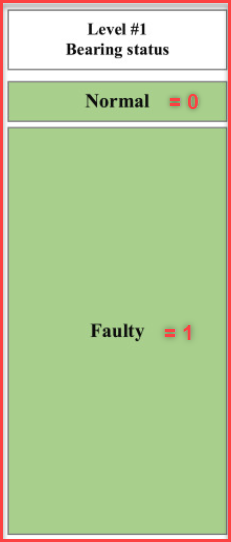

In [64]:
d_Normal_Bearing_status = (1658,)
y_Normal_Bearing_status = np.zeros(d_Normal_Bearing_status, dtype=int)
print("label 0 for Normal_Bearing_status: ", y_Normal_Bearing_status.shape)
print(y_Normal_Bearing_status[0])
print(type(y_Normal_Bearing_status))

d_Faulty_Bearing_status = (6191,)
y_Faulty_Bearing_status = np.ones(d_Faulty_Bearing_status, dtype=int)
print("label 1 for y_Faulty_Bearing_status: ", y_Faulty_Bearing_status.shape)
print(y_Faulty_Bearing_status[0])
print(type(y_Faulty_Bearing_status))


label 0 for Normal_Bearing_status:  (1658,)
0
<class 'numpy.ndarray'>
label 1 for y_Faulty_Bearing_status:  (6191,)
1
<class 'numpy.ndarray'>


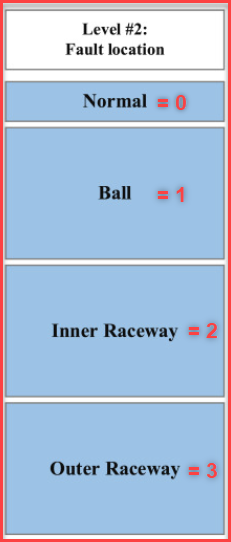

In [65]:
d_n = (1658, )
y_normal = np.zeros(d_n, dtype=int)
print("label 0 for normal data ", y_normal.shape)
print(type(y_normal))

d_b = (1427, )
y_ball = np.ones(d_b, dtype=int)
print("label 1 for faulty ball bearing data ", y_ball.shape)
print(type(y_ball))

d_ir = (1427, )
y_ir = np.ones(d_ir, dtype=int) * 2
print("label 2 for faulty inner raceway data ", y_ir.shape)
print(type(y_ir))

d_or = (3337, )
y_or = np.ones(d_or, dtype=int) * 3
print("label 3 for faulty outer raceway data ", y_or.shape)
print(type(y_or))
print('----------------------------------------')

print("label 0 for normal data: ", y_normal[0])
print("label 1 for faulty ball bearing data: ", y_ball[0])
print("label 2 for faulty inner raceway data: ", y_ir[0])
print("label 3 for faulty outer raceway data: ", y_or[0])


label 0 for normal data  (1658,)
<class 'numpy.ndarray'>
label 1 for faulty ball bearing data  (1427,)
<class 'numpy.ndarray'>
label 2 for faulty inner raceway data  (1427,)
<class 'numpy.ndarray'>
label 3 for faulty outer raceway data  (3337,)
<class 'numpy.ndarray'>
----------------------------------------
label 0 for normal data:  0
label 1 for faulty ball bearing data:  1
label 2 for faulty inner raceway data:  2
label 3 for faulty outer raceway data:  3


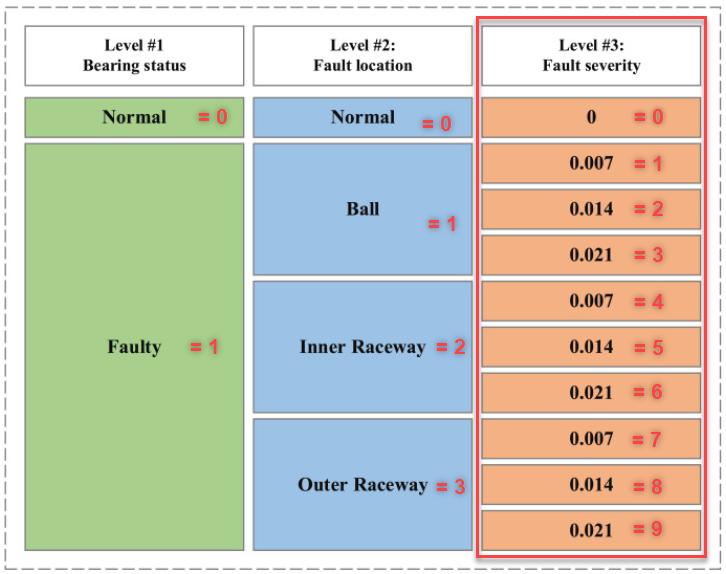

In [66]:
d_normal_fault_diameter = (1658, )
y_normal_fault_diameter = np.zeros(d_normal_fault_diameter, dtype=int)
print("y_normal_fault_diameter.shape ", y_normal_fault_diameter.shape)
print("label 0 for normal data:  ", y_normal_fault_diameter[0])
print(type(y_normal_fault_diameter))

d_ball_fault_diameter_007 = (475, )
y_ball_fault_diameter_007 = np.ones(d_ball_fault_diameter_007, dtype=int)
print("y_ball_fault_diameter_007.shape ", y_ball_fault_diameter_007.shape)
print("label 1 for y_ball_fault_diameter_007: ", y_ball_fault_diameter_007[0])
print(type(y_ball_fault_diameter_007))

d_ball_fault_diameter_014 = (476, )
y_ball_fault_diameter_014 = np.ones(d_ball_fault_diameter_014, dtype=int) * 2
print("y_ball_fault_diameter_014.shape ", y_ball_fault_diameter_014.shape)
print("label 2 for y_ball_fault_diameter_014: ", y_ball_fault_diameter_014[0])
print(type(y_ball_fault_diameter_014 ))

d_ball_fault_diameter_021 = (476, )
y_ball_fault_diameter_021 = np.ones(d_ball_fault_diameter_021, dtype=int) * 3
print("y_ball_fault_diameter_021.shape ", y_ball_fault_diameter_021.shape)
print("label 3 for y_ball_fault_diameter_021: ", y_ball_fault_diameter_021[0])
print(type(y_ball_fault_diameter_021 ))

d_ir_fault_diameter_007 = (476, )
y_ir_fault_diameter_007 = np.ones(d_ir_fault_diameter_007, dtype=int) * 4
print("y_ir_fault_diameter_007.shape ", y_ir_fault_diameter_007.shape)
print("label 4 for y_ir_fault_diameter_007: ", y_ir_fault_diameter_007[0])
print(type(y_ir_fault_diameter_007))

d_ir_fault_diameter_014 = (475, )
y_ir_fault_diameter_014 = np.ones(d_ir_fault_diameter_014, dtype=int) * 5
print("y_ir_fault_diameter_014.shape ", y_ir_fault_diameter_014.shape)
print("label 5 for y_ir_fault_diameter_014: ", y_ir_fault_diameter_014[0])
print(type(y_ir_fault_diameter_014))

d_ir_fault_diameter_021 = (476, )
y_ir_fault_diameter_021 = np.ones(d_ir_fault_diameter_021, dtype=int) * 6
print("y_ir_fault_diameter_021.shape ", y_ir_fault_diameter_021.shape)
print("label 6 for y_ir_fault_diameter_021: ", y_ir_fault_diameter_021[0])
print(type(y_ir_fault_diameter_021))

d_or_fault_diameter_007 = (1430, )
y_or_fault_diameter_007 = np.ones(d_or_fault_diameter_007, dtype=int) * 7
print("y_or_fault_diameter_007.shape ", y_or_fault_diameter_007.shape)
print("label 7 for y_or_fault_diameter_007: ", y_or_fault_diameter_007[0])
print(type(y_or_fault_diameter_007))

d_or_fault_diameter_014 = (476, )
y_or_fault_diameter_014 = np.ones(d_or_fault_diameter_014, dtype=int) * 8
print("y_or_fault_diameter_014.shape ", y_or_fault_diameter_014.shape)
print("label 8 for y_or_fault_diameter_014: ", y_or_fault_diameter_014[0])
print(type(y_or_fault_diameter_014))

d_or_fault_diameter_021 = (1431, )
y_or_fault_diameter_021 = np.ones(d_or_fault_diameter_021, dtype=int) * 9
print("y_or_fault_diameter_021.shape ", y_or_fault_diameter_021.shape)
print("label 9 for y_or_fault_diameter_021: ", y_or_fault_diameter_021[0])
print(type(y_or_fault_diameter_021))


y_normal_fault_diameter.shape  (1658,)
label 0 for normal data:   0
<class 'numpy.ndarray'>
y_ball_fault_diameter_007.shape  (475,)
label 1 for y_ball_fault_diameter_007:  1
<class 'numpy.ndarray'>
y_ball_fault_diameter_014.shape  (476,)
label 2 for y_ball_fault_diameter_014:  2
<class 'numpy.ndarray'>
y_ball_fault_diameter_021.shape  (476,)
label 3 for y_ball_fault_diameter_021:  3
<class 'numpy.ndarray'>
y_ir_fault_diameter_007.shape  (476,)
label 4 for y_ir_fault_diameter_007:  4
<class 'numpy.ndarray'>
y_ir_fault_diameter_014.shape  (475,)
label 5 for y_ir_fault_diameter_014:  5
<class 'numpy.ndarray'>
y_ir_fault_diameter_021.shape  (476,)
label 6 for y_ir_fault_diameter_021:  6
<class 'numpy.ndarray'>
y_or_fault_diameter_007.shape  (1430,)
label 7 for y_or_fault_diameter_007:  7
<class 'numpy.ndarray'>
y_or_fault_diameter_014.shape  (476,)
label 8 for y_or_fault_diameter_014:  8
<class 'numpy.ndarray'>
y_or_fault_diameter_021.shape  (1431,)
label 9 for y_or_fault_diameter_021:  9


In [124]:
import keras
from keras.utils.data_utils import get_file
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
import pandas as pd
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from numpy import asarray
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [125]:
Data = np.concatenate((Normal_fault_severity, ball_fault_diameter_007,
                 ball_fault_diameter_014, ball_fault_diameter_021,
                 ir_fault_diameter_007, ir_fault_diameter_014,
                 ir_fault_diameter_021, or_fault_diameter_007,
                 or_fault_diameter_014, or_fault_diameter_021), axis=0)
print(Data.shape)

labels = np.concatenate((y_normal_fault_diameter, y_ball_fault_diameter_007,
                 y_ball_fault_diameter_014, y_ball_fault_diameter_021,
                 y_ir_fault_diameter_007, y_ir_fault_diameter_014,
                 y_ir_fault_diameter_021, y_or_fault_diameter_007,
                 y_or_fault_diameter_014, y_or_fault_diameter_021), axis=0)
print(labels.shape)
print(labels)

(7849, 1024)
(7849,)
[0 0 0 ... 9 9 9]


In [126]:
X_train, X_test, y_train, y_test = train_test_split(Data, labels, test_size=0.2, 
                                               random_state = 8)

In [127]:
print("X_train shape: {}, dtype: {}".format(X_train.shape, type(X_train)))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (6279, 1024), dtype: <class 'numpy.ndarray'>
X_test shape: (1570, 1024)
y_train shape: (6279,)
y_test shape: (1570,)


In [128]:
# Define the number of classes

COARSE_1_CATEGORIES = ['0', '1']
COARSE_2_CATEGORIES = ['0', '1', '2', '3']
FINE_CATEGORIES = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
NB_COARSE_1_CLASSES = 2
NB_COARSE_2_CLASSES = 4
NB_FINE_CLASSES = 10

#Definining the mapping fine: coarse
coarse_2_to_coarse_1 = {0:0, 1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1}
fine_to_coarse_2 = {0:0, 1:1, 2:1, 3:1, 4:2, 5:2, 6:2, 7:3, 8:3, 9:3}

#Creating empty matrices for the coarse labels of the train and test sets with the appropriate shapes
y_coarse_2_train = np.zeros(y_train.shape[0]).astype("float32")
y_coarse_2_test = np.zeros(y_test.shape[0]).astype("float32")
y_coarse_1_train = np.zeros(y_train.shape[0]).astype("float32")
y_coarse_1_test = np.zeros(y_test.shape[0]).astype("float32")

print(y_coarse_2_train.shape)
print(y_coarse_2_test.shape)

print(y_coarse_1_train.shape)
print(y_coarse_1_test.shape)

#Filling up the matrices accordingly by putting 1 in the column corresponding to the correct coarse class
for i in range(y_coarse_2_train.shape[0]):
  y_coarse_2_train[i] = fine_to_coarse_2[y_train[i]]

for i in range(y_coarse_2_test.shape[0]):
  y_coarse_2_test[i] = fine_to_coarse_2[y_test[i]]

for i in range(y_coarse_1_train.shape[0]):
  y_coarse_1_train[i] = coarse_2_to_coarse_1[y_train[i]]
for i in range(y_coarse_1_test.shape[0]):
  y_coarse_1_test[i] = coarse_2_to_coarse_1[y_test[i]]
  

(6279,)
(1570,)
(6279,)
(1570,)


In [129]:
print(y_coarse_2_train.shape)
print(y_coarse_2_test.shape)

print(y_coarse_1_train.shape)
print(y_coarse_1_test.shape)

print(y_coarse_2_train)
print(y_coarse_2_test)

print(y_coarse_1_train)
print(y_coarse_1_test)

(6279,)
(1570,)
(6279,)
(1570,)
[2. 0. 0. ... 1. 0. 3.]
[0. 0. 3. ... 1. 3. 1.]
[1. 0. 0. ... 1. 0. 1.]
[0. 0. 1. ... 1. 1. 1.]


In [130]:
y_test = tf.keras.utils.to_categorical(y_test, num_classes = NB_FINE_CLASSES)
y_train = tf.keras.utils.to_categorical(y_train, num_classes = NB_FINE_CLASSES)
y_coarse_2_test = tf.keras.utils.to_categorical(y_coarse_2_test, num_classes = NB_COARSE_2_CLASSES)
y_coarse_2_train = tf.keras.utils.to_categorical(y_coarse_2_train, num_classes = NB_COARSE_2_CLASSES)
y_coarse_1_test = tf.keras.utils.to_categorical(y_coarse_1_test, num_classes = NB_COARSE_1_CLASSES)
y_coarse_1_train = tf.keras.utils.to_categorical(y_coarse_1_train, num_classes = NB_COARSE_1_CLASSES)

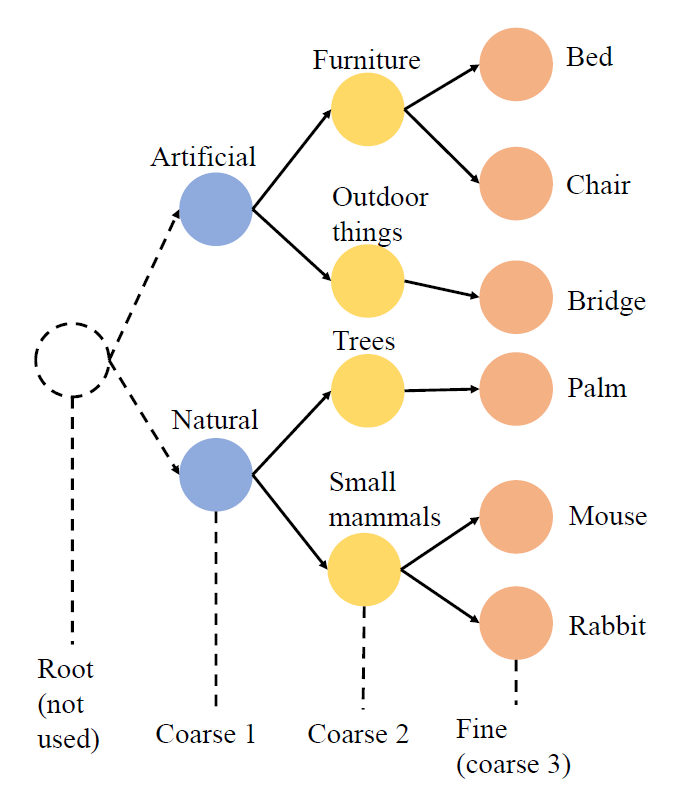

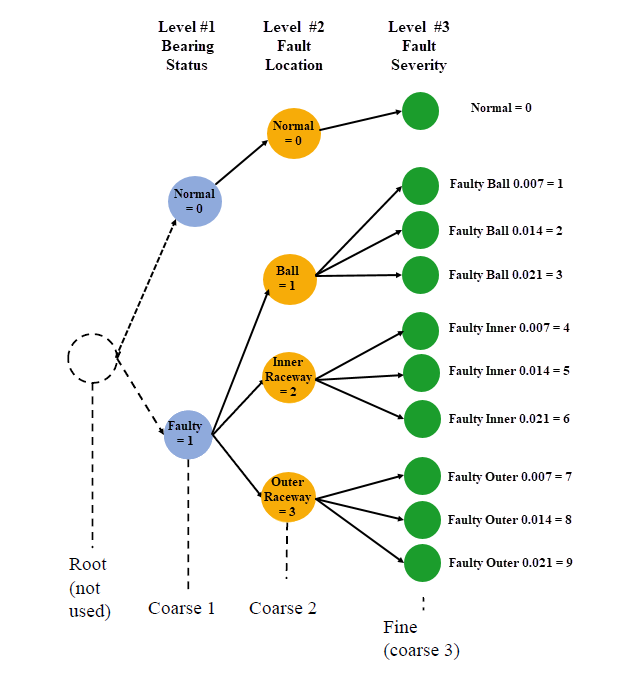

In [135]:
print(y_test.shape)
print(y_train.shape)
print(y_coarse_2_test.shape)
print(y_coarse_2_train.shape)
print(y_coarse_1_test.shape)
print(y_coarse_1_train.shape)

# Succeed in Filling up the matrices accordingly, now coarse 1 has labels 0,1
# Coarse 2 has labels 0,1,2,3
# Fine has labels 0,1,2,3,4,5,6,7,8,9

print(y_test)
print(y_train)
print(y_coarse_2_test)
print(y_coarse_2_train)
print(y_coarse_1_test)
print(y_coarse_1_train)

(1570, 10)
(6279, 10)
(1570, 4)
(6279, 4)
(1570, 2)
(6279, 2)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]
[[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [134]:
# reshaping dimesion so we can feed the signal into the model
X_train = X_train.reshape(-1, 1024, 1)
X_test = X_test.reshape(-1, 1024, 1)

print("X_train_shape", X_train.shape)
print("X_test_shape", X_test.shape)

X_train_shape (6279, 1024, 1)
X_test_shape (1570, 1024, 1)


## **Model Description**
## **3.1. Branch Convolutional Neural Network**
The overview architecture of Branch Convolutional Neural
Network (B-CNN) is shown in Figure 1a and a corresponding
label tree is in Figure 1b. In the label tree, fine
labels are target classes and are always provided by the classification
task. They are presented as leaves and clustered
into coarse categories which can be manually constructed
or generated by unsupervised methods. More general categories
can be used, e.g., coarse 1 level in Figure 1b is a
super-level of coarse 2. In order not to cause ambiguity,
we use level to refer to the different layers in the label tree,
layer as the layers in the neural network and branch as the
branch output nets of B-CNN.
A B-CNN model uses existent CNN components as
building blocks to construct a network with internal output
branches. The network shown at the bottom in Figure 1a
is a traditional convolutional neural network. It can be an
arbitrary ConvNet with multiple layers. The middle part in
Figure 1a shows the output branch networks of a B-CNN.
Each branch net produces a prediction on the corresponding
level in the label tree (Figure 1b, shown in same color). On
the top of each branch, fully connected layers and a softmax
layer are used to produce the output in one-hot representation.
Branch nets can consist of ConvNets and fully
connected neural networks. But for simplicity, in our experiments,
we only use fully connected neural networks as
our branch nets.
When doing classification, a B-CNN model outputs as
many predictions as the levels the corresponding label tree
has. For example, considering the label tree shown in Figure
1b, an image of a mouse will contain a hierarchical label of
[natural, small mammals, mouse]. When the image is fed
into B-CNN, the network will output three corresponding
predictions as the data flow through and each level’s loss
will contribute to the final loss function (introduced in 3.2)
base on the loss weights distribution (introduced in 3.3).

## **3.2. Loss Function**
The loss function of B-CNN is a weighted summation of
all coarse and find prediction losses. The loss function is
defined in (1):

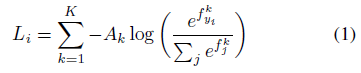

where i denotes the ith sample in the mini-batch. K is
the number of coarse levels in the label tree and Ak is the
loss weight (introduced in 3.3) of kth level contributing to the loss function.

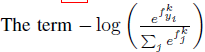

is the crossentropy
loss of the ith sample on the kth level in the label
tree and we use fj to denote the jth element in the vector f
of class scores, outputted by the last layer of the model.
The loss function takes all levels’ loss into account to
make sure the structure prior can play a role of internal
guide to the whole model and make it easier to flow the
gradients back to the shallow layers.

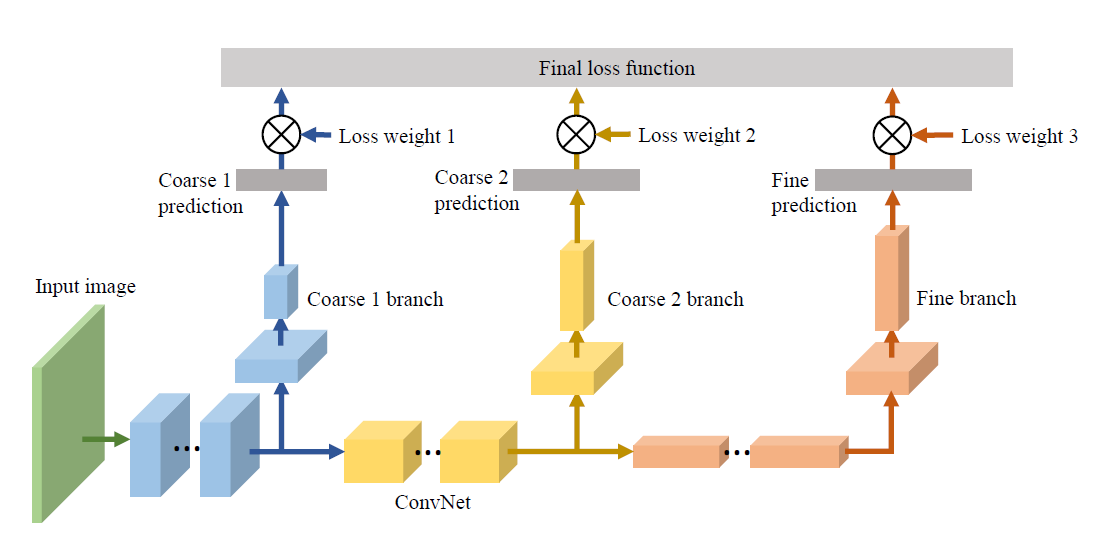

In [ ]:
#np.random.seed(0)
INPUT_SHAPE = (6279, 1024, 1)
#Model input
model_input = Input(shape=INPUT_SHAPE, name='signal_input')

#Block 1
model = Conv2D(64, (3,3), padding='same', activation='relu', name='block1_conv1')(model_input)
model = BatchNormalization()(model)
model = Conv2D(64, (3,3), padding='same', activation='relu', name='block1_conv2')(model)
model = BatchNormalization()(model)
model = MaxPooling2D((2,2), strides=(2,2), name='block1_pool')(model)
#Block 2
model = Conv2D(128, (3,3), padding='same', activation='relu', name='block2_conv1')(model)
model = BatchNormalization()(model)
model = Conv2D(128, (3,3), padding='same', activation='relu', name='block2_conv2')(model)
model = BatchNormalization()(model)
model = MaxPooling2D((2,2), strides=(2,2), name='block2_pool')(model)

#Block 3
model = Conv2D(256, (3,3), padding='same', activation='relu', name='block3_conv1')(model)
model = BatchNormalization()(model)
model = Conv2D(256, (3,3), padding='same', activation='relu', name='block3_conv2')(model)
model = BatchNormalization()(model)
model = Conv2D(256, (3,3), padding='same', activation='relu', name='block3_conv3')(model)
model = BatchNormalization()(model)
model = MaxPooling2D((2,2), strides=(2,2), name='block3_pool')(model)

coarse = Flatten(name='c_flatten')(model)
coarse = Dense(256, activation='relu', name='c_dense1')(coarse)
coarse = BatchNormalization()(coarse)
coarse = Dropout(0.5)(coarse)
coarse = Dense(256, activation='relu', name='c_dense2')(coarse)
coarse = BatchNormalization()(coarse)
coarse = Dropout(0.5)(coarse)
coarse_pred = Dense(NB_COARSE_1_CLASSES, activation='softmax', name='coarse_prediction')(coarse)

## **3.3. LossWeight**
Value Ak in (1) is the loss weight of each branch network
in B-CNN. This value defines how much contribution
a level makes to the final loss function. Although only relative
value matters how the loss function works, we use a standard representation in our experiments that each Ak
should be a value between 0 and 1 (both included) and their
summation should be 1, e.g., we use loss weights [0.1, 0.1,
0.8] for a three level label tree instead of [1, 1, 8].
This definition of loss weight also makes the B-CNN a
super model of traditional CNN. For instance, for a threebranch
B-CNN (corresponding to a three level label tree),
when loss weights are fixed to [0, 0, 1], the B-CNN model
converges to a traditional CNN model with only the last output
branch trainable. With loss weights of [1, 0, 0], the BCNN
will only activate the former part of the whole network
remaining the two higher levels untrained. The distribution
of loss weights also indicates the importance of each level,
e.g., loss weights of [0.98, 0.01, 0.01] mean the model values
the low level feature extraction but also want to train
a little bit of the deep layers, and in our experiments, we
usually use this assignment as the initialization of our loss
weights.


## **3.4. Branch Training Strategy**
Our Branch Training strategy (BT-strategy) exploits the
potential of loss weights distribution to achieve an end-toend
training procedure with low impact of vanishing gradient
problem [11]. BT-strategy modifies the loss weights
distribution while training a B-CNN model, e.g., for a two
level classification, the initial loss weights can be assigned
as [0.9, 0.1], and then they can be changed to [0.2, 0.8] after
50 epochs.
The greatest value in a loss weights assignment can be
regarded as a “focus”, e.g., 0.5 is the focus of [0.2, 0.3,
0.5]. A “focus” is not necessary in a distribution as all levels
can be equally important. However, in our implementation,
we usually set a “focus” to explicitly tell the classifier
to learn this level with more efforts. Usually, the “focus”
of a distribution will shift from lower level to higher level
(from coarse to fine). This procedure requires the classifier
to extract lower features first with coarse instructions and
fine tune parameters with fine instructions later. It to an extent
prevents the vanishing gradient problem which would
make the updates to parameters on lower layers very difficult
when the network is very deep.

In [79]:
#loss_w1: Loss weight for the coarse_1 branch
#loss_w2: Loss weight for the coarse_2 branch
#loss_w3: Loss weight for the fine branch 

class ModifyLossWeights(keras.callbacks.Callback):
    def __init__(self, loss_w1, loss_w2, loss_w3):
        self.loss_w1 = loss_w1
        self.loss_w2 = loss_w2
        self.loss_w3 = loss_w3
    # customize your behavior
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 8:
            keras.backend.set_value(self.loss_w1, 0.1)
            keras.backend.set_value(self.loss_w2, 0.8)
            keras.backend.set_value(self.loss_w3, 0.1)
        if epoch == 18:
            keras.backend.set_value(self.loss_w1, 0.1)
            keras.backend.set_value(self.loss_w2, 0.2)
            keras.backend.set_value(self.loss_w3, 0.7)
        if epoch == 28:
            keras.backend.set_value(self.loss_w1, 0)
            keras.backend.set_value(self.loss_w2, 0)
            keras.backend.set_value(self.loss_w3, 1)

In [80]:
loss_w1 = keras.backend.variable(value=0.2, dtype="float32", name="coarse_1_loss_weight") 
loss_w2 = keras.backend.variable(value=0.3, dtype="float32", name="coarse_2_loss_weight")
loss_w3 = keras.backend.variable(value=0.5, dtype="float32", name="fine_loss_weight")  

#Preparing the callback:
loss_w_modif = ModifyLossWeights(loss_w1, loss_w2, loss_w3)

bcnn_losses = {"coarse_1_prediction": "categorical_crossentropy",
               "coarse_2_prediction": "categorical_crossentropy",
               "fine_pred": "categorical_crossentropy"}

In [ ]:
model = Model(inputs=model_input, outputs=[coarse_1_prediction, coarse_2_prediction, fine_pred])   
opt = SGD(lr=0.0001, momentum=0.9)
model.compile(optimizer=opt, loss=bcnn_losses, metrics=['accuracy'], loss_weights=[loss_w1, loss_w2])

In [ ]:
# #y_merged_test = np.concatenate((y_coarse_test, y_test), axis = 1)
# #y_merged_train = np.concatenate((y_coarse_train, y_train), axis = 1 )
# 
# #callbacks=[loss_w_modif]


history_model = model.fit(X_train, [y_coarse_train,y_train], batch_size=50, epochs=50, callbacks=[loss_w_modif], verbose=1, validation_split=0.1)  
print("Val Score: ", model.evaluate(X_test, [y_coarse_test, y_test]))

In [ ]:
model = Model(inputs=model_input, outputs=[coarse_1_prediction, coarse_2_prediction, fine_pred])   
model.load_weights(weights, by_name=True)
opt = SGD(lr=0.0001, momentum=0.9)
model.compile(optimizer=opt, loss=bcnn_losses, metrics=['accuracy'], loss_weights=[loss_w1, loss_w2])